In [ ]:
!unzip -qq /kaggle/working/ai_real_2.zip

In [ ]:
train = "/kaggle/working/train"
validation = "/kaggle/working/validation"
test = "/kaggle/working/test"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1.0/255)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    shuffle=True,
                                                    seed=123)

validation_generator = validation_datagen.flow_from_directory(validation,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='binary',
                                                              classes=['real', 'fake'],
                                                              target_size=(IMG_SIZE, IMG_SIZE),
                                                              shuffle=False)



Found 36480 images belonging to 2 classes.
Found 12160 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# trainable true
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,131,620 (15.76 MB)

 Trainable params: 4,089,597 (15.60 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    # callbacks=[early_stopping]
                    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 303s 97ms/step - acc: 0.9154 - loss: 0.2300 - precision: 0.9073 - recall: 0.9278 - val_acc: 0.6973 - val_loss: 0.7151 - val_precision: 0.9781 - val_recall: 0.4036
Epoch 2/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 209s 91ms/step - acc: 0.9636 - loss: 0.1058 - precision: 0.9573 - recall: 0.9701 - val_acc: 0.8812 - val_loss: 0.3596 - val_precision: 0.8091 - val_recall: 0.9977
Epoch 3/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 211s 93ms/step - acc: 0.9714 - loss: 0.0826 - precision: 0.9674 - recall: 0.9760 - val_acc: 0.9733 - val_loss: 0.0738 - val_precision: 0.9724 - val_recall: 0.9742
Epoch 4/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 261s 92ms/step - acc: 0.9757 - loss: 0.0708 - precision: 0.9729 - recall: 0.9785 - val_acc: 0.9805 - val_loss: 0.0550 - val_precision: 0.9785 - val_recall: 0.9826
Epoch 5/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 209s 92ms/step - acc: 0.9793 - loss: 0.0569 - precision: 0.9749 - recall: 0.9838 - val_acc: 0.9456 - val_loss: 0.1435 - val_precision: 0.9615 - val_r

In [ ]:
model.evaluate(validation_generator, steps=len(validation_generator), verbose=1)

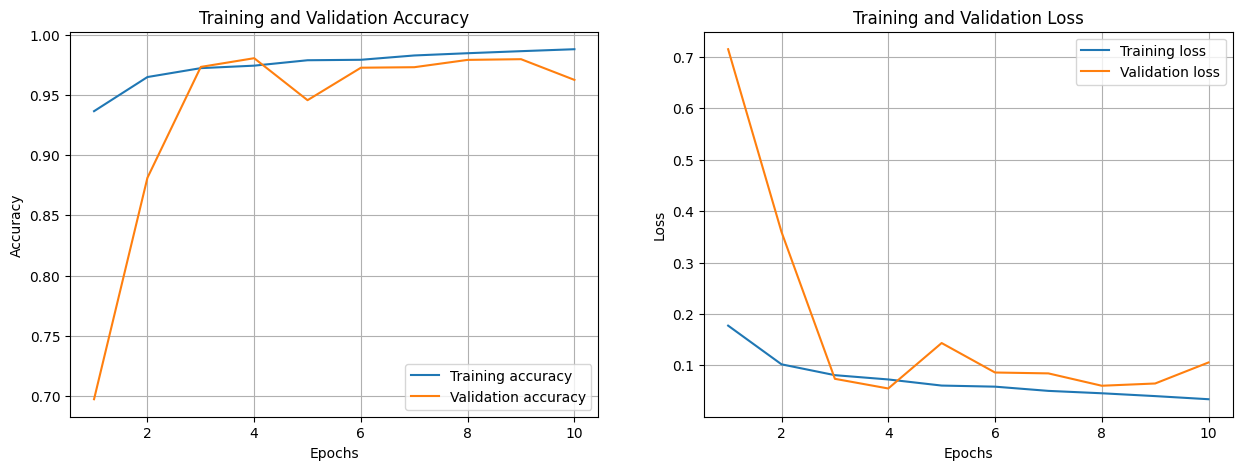

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs, acc, label='Training accuracy')
ax[0].plot(epochs, val_acc, label='Validation accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, loss, label='Training loss')
ax[1].plot(epochs, val_loss, label='Validation loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.show()






760/760 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step


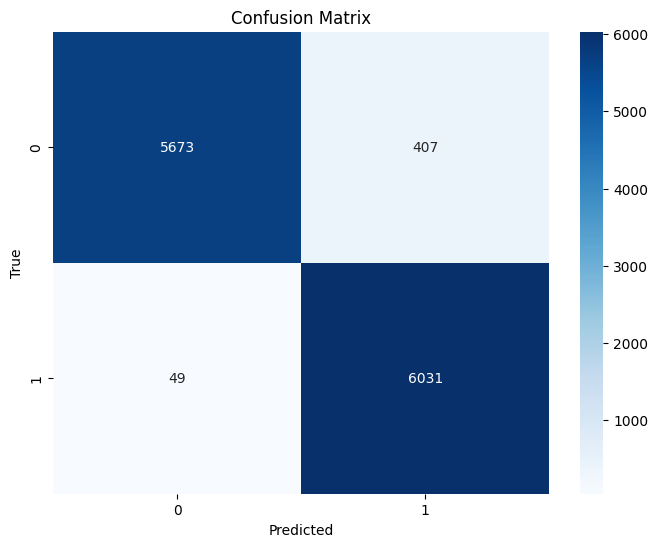

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

predicted_classes = np.round(predictions)

true_classes = validation_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      6080
           1       0.94      0.99      0.96      6080

    accuracy                           0.96     12160
   macro avg       0.96      0.96      0.96     12160
weighted avg       0.96      0.96      0.96     12160



In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  shuffle=False)

Found 12162 images belonging to 2 classes.


In [ ]:
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
test_predicted_classes = np.round(test_predictions)
test_true_classes = test_generator.classes
cm = confusion_matrix(test_true_classes, test_predicted_classes)

  2/761 ━━━━━━━━━━━━━━━━━━━━ 1:10 93ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


761/761 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step


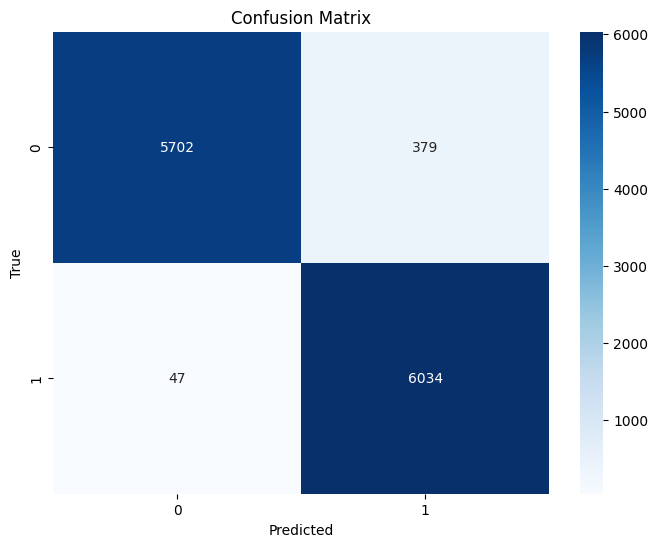

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(test_true_classes, test_predicted_classes))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      6081
           1       0.94      0.99      0.97      6081

    accuracy                           0.96     12162
   macro avg       0.97      0.96      0.96     12162
weighted avg       0.97      0.96      0.96     12162



In [ ]:
model.save('model.h5')